In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Exploring the dataset

In [10]:
metadata_train = pd.read_csv('../input/cardiodiseasedataset/train.csv')
metadata_test = pd.read_csv('../input/cardiodiseasedataset/test.csv')

In [11]:
print("Training DataFrame : \n")
print(metadata_train.info(), "\n")
with pd.option_context('display.max_rows', 5):
    display(metadata_train)
    
print("""\n\n-------------------------------------
\n\nTesting DataFrame :
""")
print(metadata_test.info(), "\n")
with pd.option_context('display.max_rows', 5):
    display(metadata_test)

Training DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6286 entries, 0 to 6285
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   filename   6286 non-null   int64
 1   target_00  6286 non-null   int64
 2   target_01  6286 non-null   int64
 3   target_02  6286 non-null   int64
 4   target_03  6286 non-null   int64
 5   target_04  6286 non-null   int64
 6   target_05  6286 non-null   int64
 7   target_06  6286 non-null   int64
 8   target_07  6286 non-null   int64
 9   target_08  6286 non-null   int64
 10  target_09  6286 non-null   int64
 11  target_10  6286 non-null   int64
 12  target_11  6286 non-null   int64
 13  target_12  6286 non-null   int64
 14  target_13  6286 non-null   int64
 15  target_14  6286 non-null   int64
 16  target_15  6286 non-null   int64
 17  target_16  6286 non-null   int64
 18  target_17  6286 non-null   int64
 19  target_18  6286 non-null   int64
 20  target_19  6286 non-null   in

,filename,target_00,target_01,target_02,target_03,target_04,target_05,target_06,target_07,target_08,...,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22
0,8272,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,7833,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6284,7648,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6285,5587,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0




-------------------------------------


Testing DataFrame :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   filename  7643 non-null   int64
dtypes: int64(1)
memory usage: 59.8 KB
None 



,filename
0,19132
1,19764
...,...
7641,11983
7642,13670


In [12]:
print("Total number of training documents :", metadata_train.shape[0])
print("Total number of test documents :", metadata_test.shape[0])

Total number of training documents : 6286
Total number of test documents : 7643


In [13]:
targets = metadata_train.drop('filename', axis=1)
counts = []
labels = list(targets.columns.values)
for i in labels:
    counts.append((i, targets[i].sum()))
df_stats = pd.DataFrame( counts, columns = ['target', 'number_of_docs'])
df_stats

,target,number_of_docs
0,target_00,423
1,target_01,158
2,target_02,65
3,target_03,1163
4,target_04,283
5,target_05,588
6,target_06,100
7,target_07,473
8,target_08,125
9,target_09,621


Text(0.5, 0, 'target')

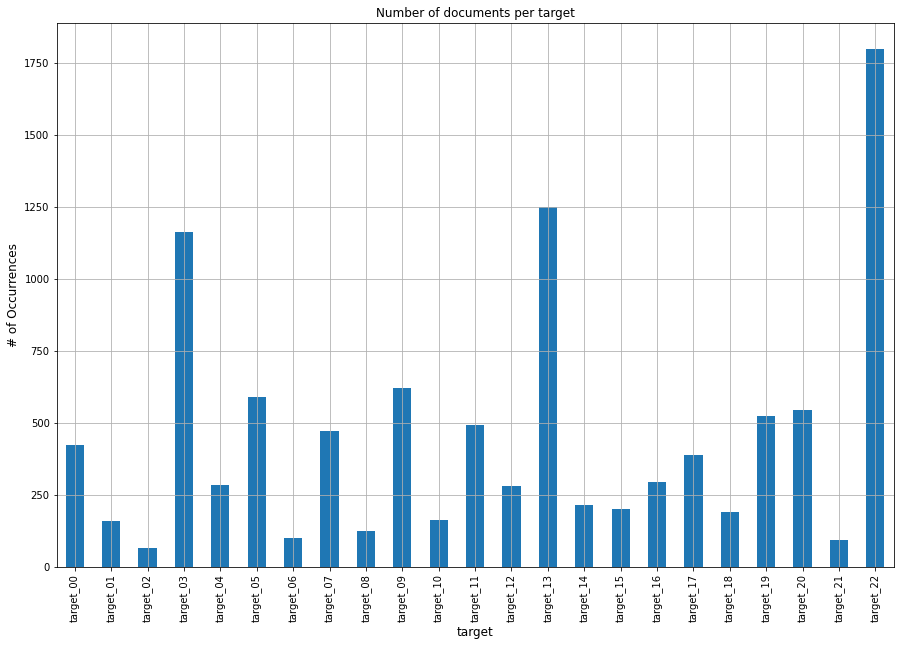

In [14]:
df_stats.plot( x = 'target', y = 'number_of_docs', kind = 'bar', legend = False, grid = True, figsize = (15, 10) )
plt.title("Number of documents per target")
plt.ylabel('# of Occurrences', fontsize = 12)
plt.xlabel('target', fontsize = 12)

How many documents have multiple labels?

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of targets')

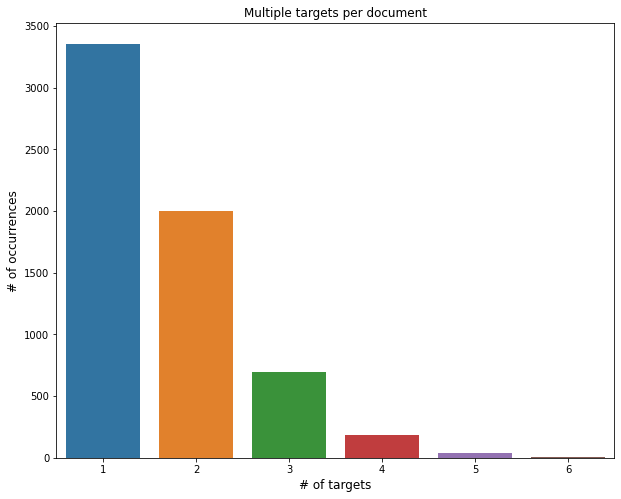

In [15]:
rowsums = metadata_train.iloc[:,1:].sum(axis = 1)
x=rowsums.value_counts()


plt.figure(figsize=(10,8))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple targets per document")
plt.ylabel('# of occurrences', fontsize = 12)
plt.xlabel('# of targets', fontsize = 12)

In [16]:
df = metadata_train.copy()

# Add a column for the text data
df['text'] = ''
text = df.pop('text')
df.insert(1, 'text', text)
df.head()

,filename,text,target_00,target_01,target_02,target_03,target_04,target_05,target_06,target_07,...,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22
0,8272,,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,7833,,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,8844,,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,6586,,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,7666,,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [17]:
f = open("../input/cardiodiseasedataset/data/data/train/C01/0000021", "r")
text = f.read()
print(text)

Augmentation mentoplasty using Mersilene mesh.
 Many different materials are available for augmentation mentoplasty.
 However, the optimal implant material for chin implantation has yet to be found.
 During the past several years, a number of experienced surgeons have turned to the use of Mersilene mesh.
 Mersilene mesh is a non-absorbable Dacron polyester fiber that can be conformed easily into layers to achieve tailored dimensions and shape.
 At the McCollough Plastic Surgery Clinic PA, Birmingham, Ala, 277 patients over a 10-year period underwent chin augmentation with Mersilene mesh implants.
 The material provides excellent tensile strength, durability, and surgical adaptability.
 The overall complication rate was 3.2% (nine patients); infection rate, 2.5% (seven patients); and removal secondary to infection, 1.7% (five patients).
 Based on this 10-year experience, Mersilene mesh remains our material of choice for chin augmentation.



In [18]:
trainpath = '../input/cardiodiseasedataset/data/data/train'


for dirname, _, filenames in os.walk(trainpath):
    for filename in filenames :
        f = open(os.path.join(dirname, filename), "r")
        text = f.read()
        df.loc[df.index[ df['filename'] == int(filename) ].tolist()[0], 'text'] = text
        #print(df[ df['filename'] == int(filename)][] ,end = " ")

In [19]:
df_test = metadata_test.copy()
df_test['text'] = ''

## The test data

testpath = '../input/cardiodiseasedataset/data/data/test'

for dirname, _, filenames in os.walk(testpath):
    for filename in filenames :
        f = open(os.path.join(dirname, filename), "r")
        text = f.read()
        df_test.loc[df_test.index[ df_test['filename'] == int(filename) ].tolist()[0], 'text'] = text

In [20]:
df.head()

,filename,text,target_00,target_01,target_02,target_03,target_04,target_05,target_06,target_07,...,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22
0,8272,Improved outcome at 28 days of age for very lo...,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,7833,Chylothorax after posterior spinal instrumenta...,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,8844,Childhood pulmonary function following hyaline...,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,6586,Treatment of atelectasis of upper lung lobes. ...,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,7666,"Decision analysis, public health policy, and i...",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [21]:
df_test.head()

,filename,text
0,19132,Pulmonary aspiration during emergency endoscop...
1,19764,Community-acquired pulmonary infections in a p...
2,15506,External fixation using microplates after lary...
3,12181,Hemoptysis. Indications for bronchoscopy.\n In...
4,14418,Eosinophilic myositis an expression of L-trypt...


<AxesSubplot:>

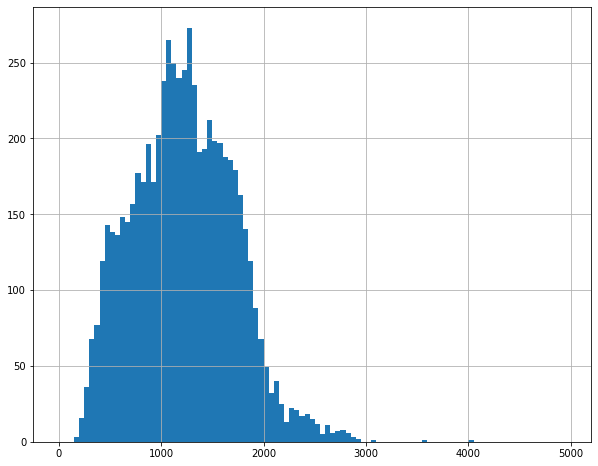

In [22]:
lens = df.text.str.len()
lens.hist(bins = np.arange(0,5000,50), figsize=(10,8))

# Preparing the data

In [23]:
targets = list(df.columns[2:])
targets

['target_00',
 'target_01',
 'target_02',
 'target_03',
 'target_04',
 'target_05',
 'target_06',
 'target_07',
 'target_08',
 'target_09',
 'target_10',
 'target_11',
 'target_12',
 'target_13',
 'target_14',
 'target_15',
 'target_16',
 'target_17',
 'target_18',
 'target_19',
 'target_20',
 'target_21',
 'target_22']

In [24]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [25]:
X_train = train.text
X_test = test.text
print(X_train.shape)
print(X_test.shape)

(4211,)
(2075,)


# Modeling 

Using **LinearSVC**

In [26]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [27]:
preds = {}

In [28]:
clfs_svc = {}

In [29]:
for target in targets :
    print('... Processing {}'.format(target))
    
    model = SVC_pipeline.fit(X_train, train[target])
    
    prediction = model.predict(X_test)
    clfs_svc[target] = model
    print('Test accuracy is {}'.format(accuracy_score(test[target], prediction)))

... Processing target_00
Test accuracy is 0.9537349397590361
... Processing target_01
Test accuracy is 0.9787951807228915
... Processing target_02
Test accuracy is 0.9903614457831326
... Processing target_03
Test accuracy is 0.9127710843373494
... Processing target_04
Test accuracy is 0.9628915662650602
... Processing target_05
Test accuracy is 0.9498795180722892
... Processing target_06
Test accuracy is 0.9889156626506024
... Processing target_07
Test accuracy is 0.9416867469879519
... Processing target_08
Test accuracy is 0.9826506024096385
... Processing target_09
Test accuracy is 0.9214457831325301
... Processing target_10
Test accuracy is 0.9812048192771085
... Processing target_11
Test accuracy is 0.9561445783132531
... Processing target_12
Test accuracy is 0.9672289156626506
... Processing target_13
Test accuracy is 0.9219277108433735
... Processing target_14
Test accuracy is 0.9725301204819277
... Processing target_15
Test accuracy is 0.9710843373493976
... Processing target_16

Using **Logistic Regression**

In [30]:
clfs_logreg = {}

In [31]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

In [32]:
for target in targets :
    print('... Processing {}'.format(target))
    
    model = LogReg_pipeline.fit(X_train, train[target])
    
    prediction = model.predict(X_test)
    clfs_logreg[target] = model
    print('Test accuracy is {}'.format(accuracy_score(test[target], prediction)))

... Processing target_00
Test accuracy is 0.9267469879518072
... Processing target_01
Test accuracy is 0.9759036144578314
... Processing target_02
Test accuracy is 0.9893975903614458
... Processing target_03
Test accuracy is 0.8906024096385542
... Processing target_04
Test accuracy is 0.9508433734939759
... Processing target_05
Test accuracy is 0.9248192771084337
... Processing target_06
Test accuracy is 0.9850602409638555
... Processing target_07
Test accuracy is 0.92
... Processing target_08
Test accuracy is 0.9802409638554217
... Processing target_09
Test accuracy is 0.9074698795180723
... Processing target_10
Test accuracy is 0.9730120481927711
... Processing target_11
Test accuracy is 0.9334939759036145
... Processing target_12
Test accuracy is 0.9546987951807229
... Processing target_13
Test accuracy is 0.8930120481927711
... Processing target_14
Test accuracy is 0.9662650602409638
... Processing target_15
Test accuracy is 0.9691566265060241
... Processing target_16
Test accuracy

In [33]:
clfs_nb = {}

In [34]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [35]:
for target in targets :
    print('... Processing {}'.format(target))
    
    model = NB_pipeline.fit(X_train, train[target])
    
    prediction = model.predict(X_test)
    clfs_nb[target] = model
    print('Test accuracy is {}'.format(accuracy_score(test[target], prediction)))

... Processing target_00
Test accuracy is 0.9253012048192771
... Processing target_01
Test accuracy is 0.9754216867469879
... Processing target_02
Test accuracy is 0.9893975903614458
... Processing target_03
Test accuracy is 0.8274698795180723
... Processing target_04
Test accuracy is 0.9513253012048193
... Processing target_05
Test accuracy is 0.9108433734939759
... Processing target_06
Test accuracy is 0.9850602409638555
... Processing target_07
Test accuracy is 0.9156626506024096
... Processing target_08
Test accuracy is 0.9802409638554217
... Processing target_09
Test accuracy is 0.9050602409638554
... Processing target_10
Test accuracy is 0.9725301204819277
... Processing target_11
Test accuracy is 0.9281927710843374
... Processing target_12
Test accuracy is 0.9532530120481928
... Processing target_13
Test accuracy is 0.8255421686746988
... Processing target_14
Test accuracy is 0.9662650602409638
... Processing target_15
Test accuracy is 0.9691566265060241
... Processing target_16

# Predicting  

In [36]:
clfs = clfs_logreg

In [37]:
test_text = df_test.text
test_text

0       Pulmonary aspiration during emergency endoscop...
1       Community-acquired pulmonary infections in a p...
2       External fixation using microplates after lary...
3       Hemoptysis. Indications for bronchoscopy.\n In...
4       Eosinophilic myositis an expression of L-trypt...
                              ...                        
7638    Cyclocryotherapy in selected cases of congenit...
7639    Treatment of exophthalmos.\n Current procedure...
7640    The potential for mental status changes associ...
7641    Epidemiologic evidence of a role for the antio...
7642    Factors associated with delay in diagnosis of ...
Name: text, Length: 7643, dtype: object

In [38]:
preds = {
    'filename' : df_test.filename.tolist() 
}

In [39]:
for target in targets :
    print('... Predicting {}'.format(target))
    prediction = clfs[target].predict(test_text)
    
    preds[target] = prediction

... Predicting target_00
... Predicting target_01
... Predicting target_02
... Predicting target_03
... Predicting target_04
... Predicting target_05
... Predicting target_06
... Predicting target_07
... Predicting target_08
... Predicting target_09
... Predicting target_10
... Predicting target_11
... Predicting target_12
... Predicting target_13
... Predicting target_14
... Predicting target_15
... Predicting target_16
... Predicting target_17
... Predicting target_18
... Predicting target_19
... Predicting target_20
... Predicting target_21
... Predicting target_22


In [40]:
submission_df = pd.DataFrame.from_dict(preds)
submission_df.head()

,filename,target_00,target_01,target_02,target_03,target_04,target_05,target_06,target_07,target_08,...,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22
0,19132,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,19764,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15506,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12181,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
submission_df.to_csv('/kaggle/working/submission.csv', index = False)